# More Data Analysis in Python - Divvy Riders
## A Google Case Study
**Lets use pandas to just get some basics stats on the data cleaned with SQL**
* Averages, mins and maxes on rider time, rider distance, and ride counts during different parts of day, week and year
* Distribution plots

In [65]:
import pandas as pd
import sqlalchemy
import psycopg2

### Sample of original data format

In [66]:
df = pd.read_csv('/Users/devonbennett/Downloads/ridersampledata.csv')
print("There are {} rows in this dataframe".format(df.shape[0]))

There are 50 rows in this dataframe


In [67]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6C992BD37A98A63F,classic_bike,2021-04-12 18:25:36,2021-04-12 18:56:55,State St & Pearson St,TA1307000061,Southport Ave & Waveland Ave,13235,41.897448,-87.628722,41.948150,-87.663940,member
1,1E0145613A209000,docked_bike,2021-04-27 17:27:11,2021-04-27 18:31:29,Dorchester Ave & 49th St,KA1503000069,Dorchester Ave & 49th St,KA1503000069,41.805772,-87.592464,41.805772,-87.592464,casual
2,E498E15508A80BAD,docked_bike,2021-04-03 12:42:45,2021-04-07 11:40:24,Loomis Blvd & 84th St,20121,Loomis Blvd & 84th St,20121,41.741487,-87.658410,41.741487,-87.658410,casual
3,1887262AD101C604,classic_bike,2021-04-17 09:17:42,2021-04-17 09:42:48,Honore St & Division St,TA1305000034,Southport Ave & Waveland Ave,13235,41.903119,-87.673935,41.948150,-87.663940,member
4,C123548CAB2A32A5,docked_bike,2021-04-03 12:42:25,2021-04-03 14:13:42,Loomis Blvd & 84th St,20121,Loomis Blvd & 84th St,20121,41.741487,-87.658410,41.741487,-87.658410,casual


### Connecting directly to Postgres Server
* And creating dataframe from SQL query on original data

In [73]:
conn = psycopg2.connect(
            host = "localhost",
            database = "GoogleCaseStudy",
            user = "postgres",
            password = "Noved@$@1994",
            port = 5432
)   

SQL_Query = pd.read_sql_query(
'''SELECT ride_id, rideable_type, start_station_name, end_station_name, start_lat, start_lng, end_lat, end_lng, member_casual,
    ROUND((EXTRACT(EPOCH FROM (ended_at - started_at))/60)::numeric,1) AS minutes_rented,
	ROUND(sqrt(((start_lat - end_lat)*69)^2 + ((start_lng-end_lng)*54.6)^2), 4) AS distance,
	date_part('hour', started_at) AS start_hour, date_part('hour', ended_at) AS end_hour,
	started_at::date AS start_date, ended_at::date AS end_date,
	(CASE WHEN EXTRACT(DOW FROM started_at) = 0 THEN 'Sunday' 
	 	WHEN EXTRACT(DOW FROM started_at) = 1 THEN 'Monday'
		WHEN EXTRACT(DOW FROM started_at) = 2 THEN 'Tuesday'
		WHEN EXTRACT(DOW FROM started_at) = 3 THEN 'Wednesday'
	 	WHEN EXTRACT(DOW FROM started_at) = 4 THEN 'Thursday'
	 	WHEN EXTRACT(DOW FROM started_at) = 5 THEN 'Friday'
	 	WHEN EXTRACT(DOW FROM started_at) = 6 THEN 'Saturday'	 
	 END) AS weekday
	
FROM annualriderdata
WHERE (ended_at - started_at) > '00:00:30'
AND (ended_at - started_at) < '02:00:00'
AND (start_station_id IS NOT NULL AND end_station_id IS NOT NULL);   
   ''', conn)

df = pd.DataFrame(SQL_Query)

#close connection
conn.close()


In [69]:
weekdaydf = df[(df.weekday != 'Saturday') & (df.weekday != 'Sunday')]
weekdaydf

,ride_id,rideable_type,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,minutes_rented,distance,start_hour,end_hour,start_date,end_date,weekday
3,0376FCC7B2B564C0,docked_bike,Southport Ave & Irving Park Rd,Clark St & Drummond Pl,41.954177,-87.664358,41.931248,-87.644336,member,18.0,1.9231,17.0,18.0,2020-10-29,2020-10-29,Thursday
4,03770B01C5AF31E9,docked_bike,Larrabee St & Kingsbury St,Racine Ave & Fullerton Ave,41.897764,-87.642884,41.925563,-87.658404,member,38.9,2.0970,13.0,14.0,2020-09-07,2020-09-07,Monday
5,03770C50515EDF2B,docked_bike,Cornell Ave & Hyde Park Blvd,Kimbark Ave & 53rd St,41.802406,-87.586924,41.799568,-87.594747,casual,23.3,0.4699,17.0,18.0,2021-04-06,2021-04-06,Tuesday
8,03770ECA6CBD0410,docked_bike,Indiana Ave & 26th St,Michigan Ave & 8th St,41.845687,-87.622481,41.872773,-87.623981,member,12.7,1.8707,18.0,18.0,2020-11-04,2020-11-04,Wednesday
11,0377171F75A936FC,docked_bike,Wells St & Huron St,Wells St & Evergreen Ave,41.894722,-87.634362,41.906724,-87.634830,casual,5.5,0.8285,0.0,0.0,2021-06-24,2021-06-24,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979313,0376C93839C0E979,docked_bike,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,41.880958,-87.616743,41.892278,-87.612043,casual,20.4,0.8222,15.0,16.0,2020-07-13,2020-07-13,Monday
3979314,0376CD4E08D473F1,classic_bike,Sheffield Ave & Wellington Ave,Lake Shore Dr & Wellington Ave,41.936266,-87.652662,41.936688,-87.636829,member,6.1,0.8650,18.0,18.0,2021-05-10,2021-05-10,Monday
3979315,0376D51390EE21EB,electric_bike,Canal St & Jackson Blvd,Damen Ave & Grand Ave,41.877271,-87.639646,41.891370,-87.677109,member,17.0,2.2650,16.0,16.0,2021-04-05,2021-04-05,Monday
3979317,0376DE5C2633AE3D,docked_bike,Damen Ave & Pierce Ave,Orleans St & Elm St,41.909396,-87.677692,41.902924,-87.637715,casual,18.5,2.2280,17.0,18.0,2020-07-10,2020-07-10,Friday


In [74]:
weekdaydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2627105 entries, 3 to 3979318
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   start_station_name  object 
 3   end_station_name    object 
 4   start_lat           float64
 5   start_lng           float64
 6   end_lat             float64
 7   end_lng             float64
 8   member_casual       object 
 9   minutes_rented      float64
 10  distance            float64
 11  start_hour          float64
 12  end_hour            float64
 13  start_date          object 
 14  end_date            object 
 15  weekday             object 
dtypes: float64(8), object(8)
memory usage: 340.7+ MB


In [75]:
round(weekdaydf.minutes_rented.mean(),2)

23.65

In [76]:
weekdaydf.describe()

,start_lat,start_lng,end_lat,end_lng,minutes_rented,distance,start_hour,end_hour
count,2.627105e+06,2.627105e+06,2.627105e+06,2.627105e+06,2.627105e+06,2.627105e+06,2.627105e+06,2.627105e+06
mean,4.190330e+01,-8.764371e+01,4.190362e+01,-8.764399e+01,2.365198e+01,1.382558e+00,1.456959e+01,1.472607e+01
std,4.096259e-02,2.355761e-02,4.108605e-02,2.368732e-02,2.228675e+02,1.209129e+00,4.742213e+00,4.870397e+00
min,4.164850e+01,-8.777470e+01,4.164850e+01,-8.777470e+01,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.188213e+01,-8.765552e+01,4.188224e+01,-8.765685e+01,7.300000e+00,5.756000e-01,1.100000e+01,1.100000e+01
50%,4.189766e+01,-8.764015e+01,4.189806e+01,-8.764107e+01,1.280000e+01,1.059500e+00,1.600000e+01,1.600000e+01
75%,4.192871e+01,-8.762775e+01,4.192883e+01,-8.762775e+01,2.310000e+01,1.856700e+00,1.800000e+01,1.800000e+01
max,4.206489e+01,-8.752823e+01,4.207551e+01,-8.752452e+01,5.569170e+04,3.017740e+01,2.300000e+01,2.300000e+01


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


<Figure size 20x20 with 0 Axes>

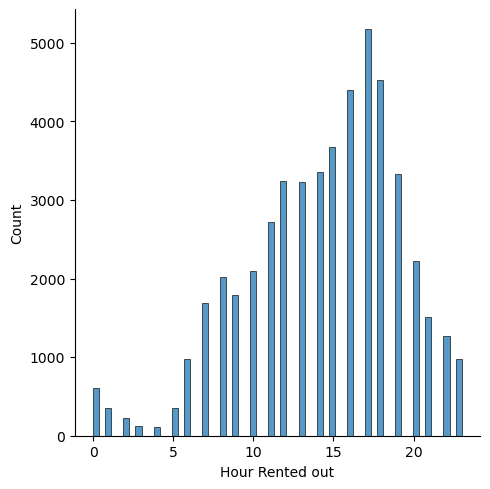

In [59]:
figsize=(10,10)
dpi=40
#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=figsize, dpi=dpi)
df.start_hour = pd.to_numeric(df.start_hour)
sns.displot(df.start_hour)
plt.xlabel('Hour Rented out')
plt.show()